<a href="https://colab.research.google.com/github/Michelleagl/Series_de_Tiempo/blob/main/Auto_ETS.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [31]:
import numpy as np
import pandas as pd
import yfinance as yf

In [32]:
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf

plt.style.use('fivethirtyeight')
plt.rcParams['lines.linewidth'] = 1.5
dark_style = {
    'figure.facecolor': '#212946',
    'axes.facecolor': '#212946',
    'savefig.facecolor':'#212946',
    'axes.grid': True,
    'axes.grid.which': 'both',
    'axes.spines.left': False,
    'axes.spines.right': False,
    'axes.spines.top': False,
    'axes.spines.bottom': False,
    'grid.color': '#2A3459',
    'grid.linewidth': '1',
    'text.color': '0.9',
    'axes.labelcolor': '0.9',
    'xtick.color': '0.9',
    'ytick.color': '0.9',
    'font.size': 12 }
plt.rcParams.update(dark_style)

from pylab import rcParams
rcParams['figure.figsize'] = (18,7)



In [33]:
stock = 'META'
ticker = yf.Ticker(stock)
df = ticker.history(start= '2013-01-01', end= '2023-12-31', interval='1mo')['Close']

df

,Close
Date,
2013-01-01 00:00:00-05:00,30.887003
2013-02-01 00:00:00-05:00,27.168201
2013-03-01 00:00:00-05:00,25.503214
2013-04-01 00:00:00-04:00,27.686640
2013-05-01 00:00:00-04:00,24.276907
...,...
2023-08-01 00:00:00-04:00,295.001801
2023-09-01 00:00:00-04:00,299.308807
2023-10-01 00:00:00-04:00,300.365631


In [34]:
df = pd.DataFrame({"ds": df.index, "y": df.values, "unique_id": "meta"})

In [35]:
print(df.dtypes)

ds           datetime64[ns, America/New_York]
y                                     float64
unique_id                              object
dtype: object


In [36]:
# Assuming 'df' is your DataFrame
df["ds"] = pd.to_datetime(df["ds"], errors='coerce')
# The 'coerce' option here will replace problematic values with NaT (Not a Time)
# NaT is how pandas represents missing dates or times

# You can now handle the rows with the NaT values by dropping or cleaning
# them as needed.
df.dropna(subset=["ds"], inplace=True)

In [37]:
!pip install statsforecast


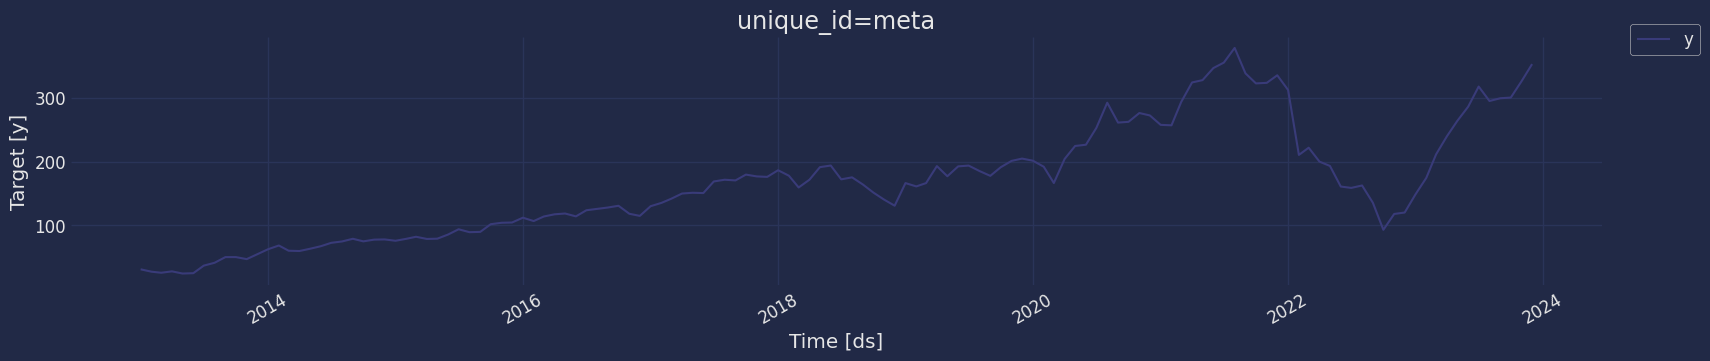

In [38]:
from statsforecast import StatsForecast

StatsForecast.plot(df)

## Autocorrelation plots

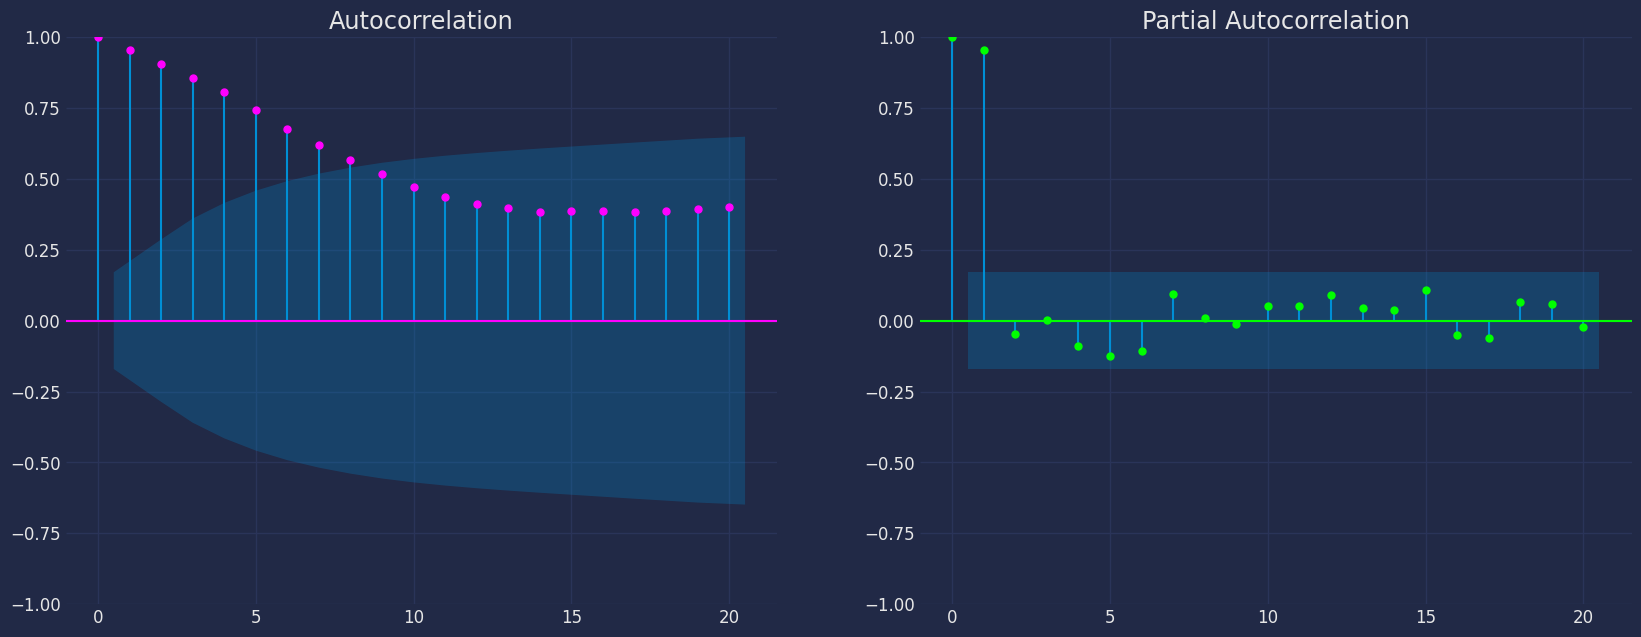

In [39]:
fig, axs = plt.subplots(nrows=1, ncols=2)

plot_acf(df["y"],  lags=20, ax=axs[0],color="fuchsia")
axs[0].set_title("Autocorrelation");

# Plot
plot_pacf(df["y"],  lags=20, ax=axs[1],color="lime")
axs[1].set_title('Partial Autocorrelation')

plt.show();

## Decomposition of the time series


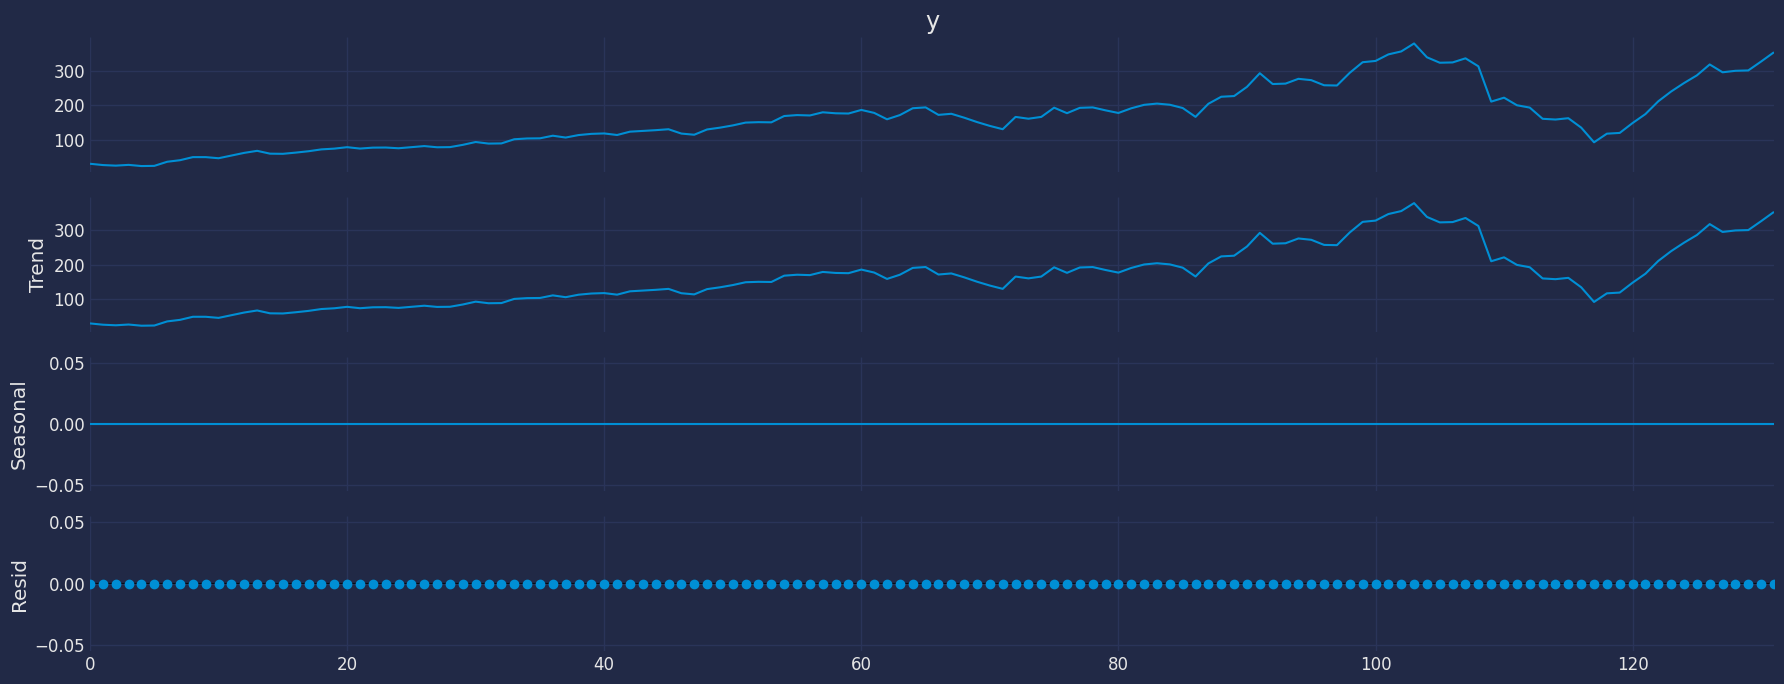

In [40]:
from statsmodels.tsa.seasonal import seasonal_decompose
a = seasonal_decompose(df["y"], model = "add", period=1)
a.plot();

## Split the data into training and testing


In [41]:
train = df[df.ds<='2021-01-01']
test = df[df.ds>'2021-01-01']


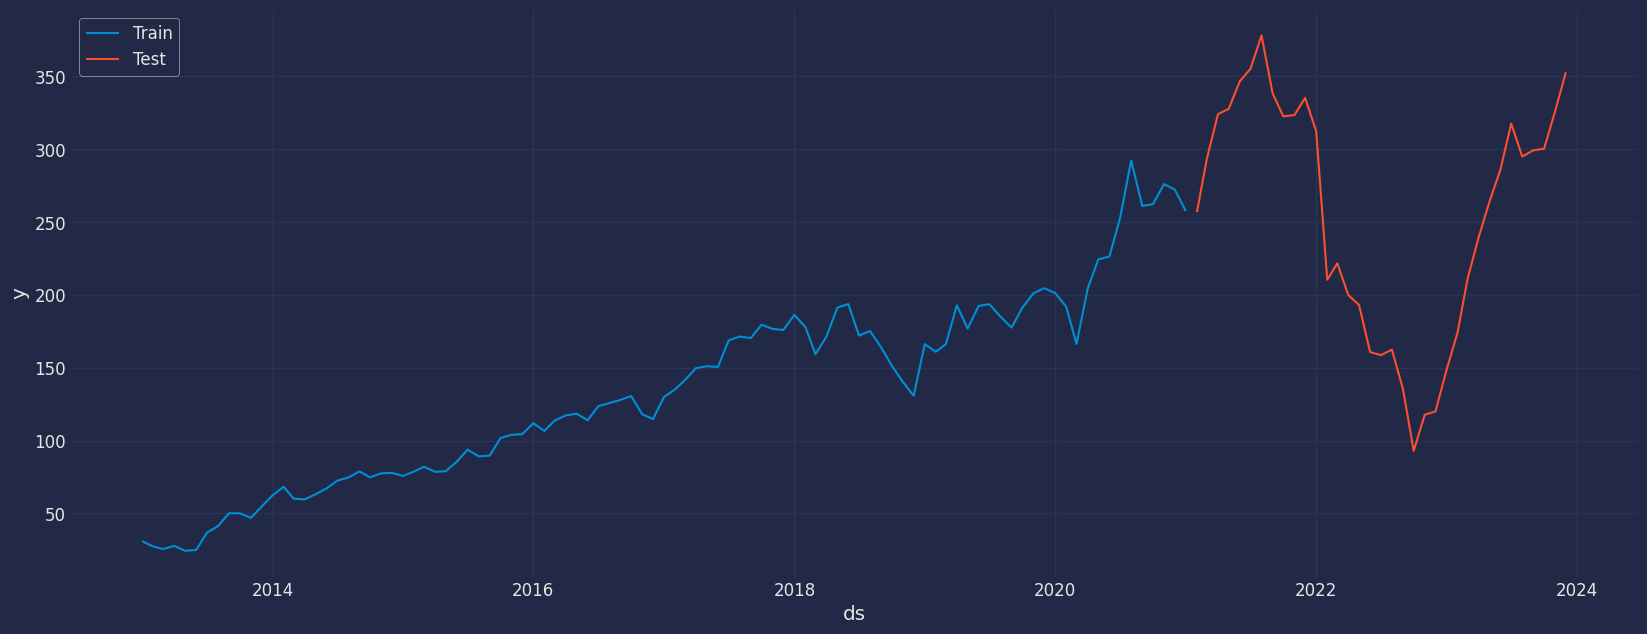

In [42]:
sns.lineplot(train,x="ds", y="y", label="Train")
sns.lineplot(test, x="ds", y="y", label="Test")
plt.show()

In [43]:
from statsforecast.models import AutoETS

In [44]:
autoets = AutoETS(model=["A","Z","N"],  alias="AutoETS", season_length=1)


In [45]:
autoets = autoets.fit(df["y"].values)
autoets


AutoETS

In [46]:
y_hat_dict = autoets.predict(h=6)
y_hat_dict

{'mean': array([352.89478773, 352.89478773, 352.89478773, 352.89478773,
        352.89478773, 352.89478773])}

In [47]:
forecast=pd.Series(pd.date_range("2020-01-01", freq="ys", periods=6))
forecast=pd.DataFrame(forecast)
forecast.columns=["ds"]
forecast["hat"]=y_hat_dict.get("mean")
forecast["unique_id"]="1"
forecast

<ipython-input-47-a6b53cadc6fc>:1: FutureWarning: 'ys' is deprecated and will be removed in a future version, please use 'YS' instead.
  forecast=pd.Series(pd.date_range("2020-01-01", freq="ys", periods=6))


,ds,hat,unique_id
0,2020-01-01,352.894788,1
1,2021-01-01,352.894788,1
2,2022-01-01,352.894788,1
3,2023-01-01,352.894788,1
4,2024-01-01,352.894788,1
5,2025-01-01,352.894788,1


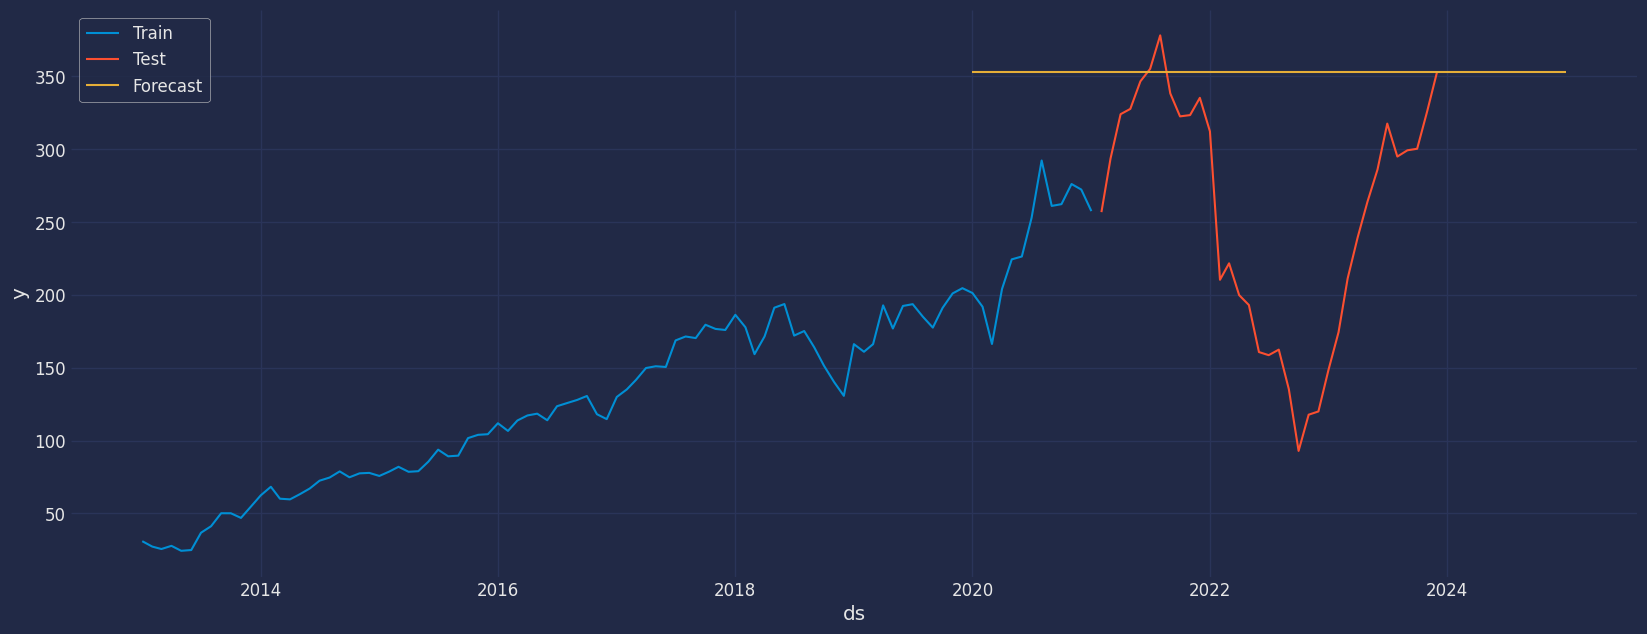

In [50]:
sns.lineplot(train,x="ds", y="y", label="Train")
sns.lineplot(test, x="ds", y="y", label="Test")
sns.lineplot(forecast,x="ds", y="hat", label="Forecast",)
plt.show()

In [51]:
# Agregando intervalos de confianza
y_hat_dict = autoets.predict(h=6, level=[80,90,95])
y_hat_dict


{'mean': array([352.89478773, 352.89478773, 352.89478773, 352.89478773,
        352.89478773, 352.89478773]),
 'lo-95': array([317.35572099, 302.63747049, 291.34342212, 281.82198505,
        273.43337601, 265.84946262]),
 'lo-90': array([323.06946273, 310.71751753, 301.23925336, 293.24861148,
        286.20866885, 279.8440481 ]),
 'lo-80': array([329.65704103, 320.0332943 , 312.64851301, 306.42277995,
        300.93776332, 295.97890889]),
 'hi-80': array([376.13253443, 385.75628115, 393.14106244, 399.36679551,
        404.85181214, 409.81066656]),
 'hi-90': array([382.72011272, 395.07205792, 404.55032209, 412.54096397,
        419.5809066 , 425.94552736]),
 'hi-95': array([388.43385446, 403.15210497, 414.44615333, 423.9675904 ,
        432.35619944, 439.94011284])}

In [52]:
forecast["hat"]=y_hat_dict.get("mean")

forecast["lo-80"]=y_hat_dict.get("lo-80")
forecast["hi-80"]=y_hat_dict.get("hi-80")

forecast["lo-90"]=y_hat_dict.get("lo-80")
forecast["hi-90"]=y_hat_dict.get("hi-80")

forecast["lo-95"]=y_hat_dict.get("lo-95")
forecast["hi-95"]=y_hat_dict.get("hi-95")
forecast

,ds,hat,unique_id,lo-80,hi-80,lo-90,hi-90,lo-95,hi-95
0,2020-01-01,352.894788,1,329.657041,376.132534,329.657041,376.132534,317.355721,388.433854
1,2021-01-01,352.894788,1,320.033294,385.756281,320.033294,385.756281,302.637470,403.152105
2,2022-01-01,352.894788,1,312.648513,393.141062,312.648513,393.141062,291.343422,414.446153
3,2023-01-01,352.894788,1,306.422780,399.366796,306.422780,399.366796,281.821985,423.967590
4,2024-01-01,352.894788,1,300.937763,404.851812,300.937763,404.851812,273.433376,432.356199
5,2025-01-01,352.894788,1,295.978909,409.810667,295.978909,409.810667,265.849463,439.940113


In [53]:
df=df.set_index("ds")
forecast=forecast.set_index("ds")

In [63]:
df['unique_id'] = df['unique_id'].astype(object)
df_plot=df.merge(forecast, how='left', on=['unique_id', 'ds'])


ValueError: You are trying to merge on datetime64[ns, America/New_York] and datetime64[ns] columns for key 'ds'. If you wish to proceed you should use pd.concat

NameError: name 'df_plot' is not defined

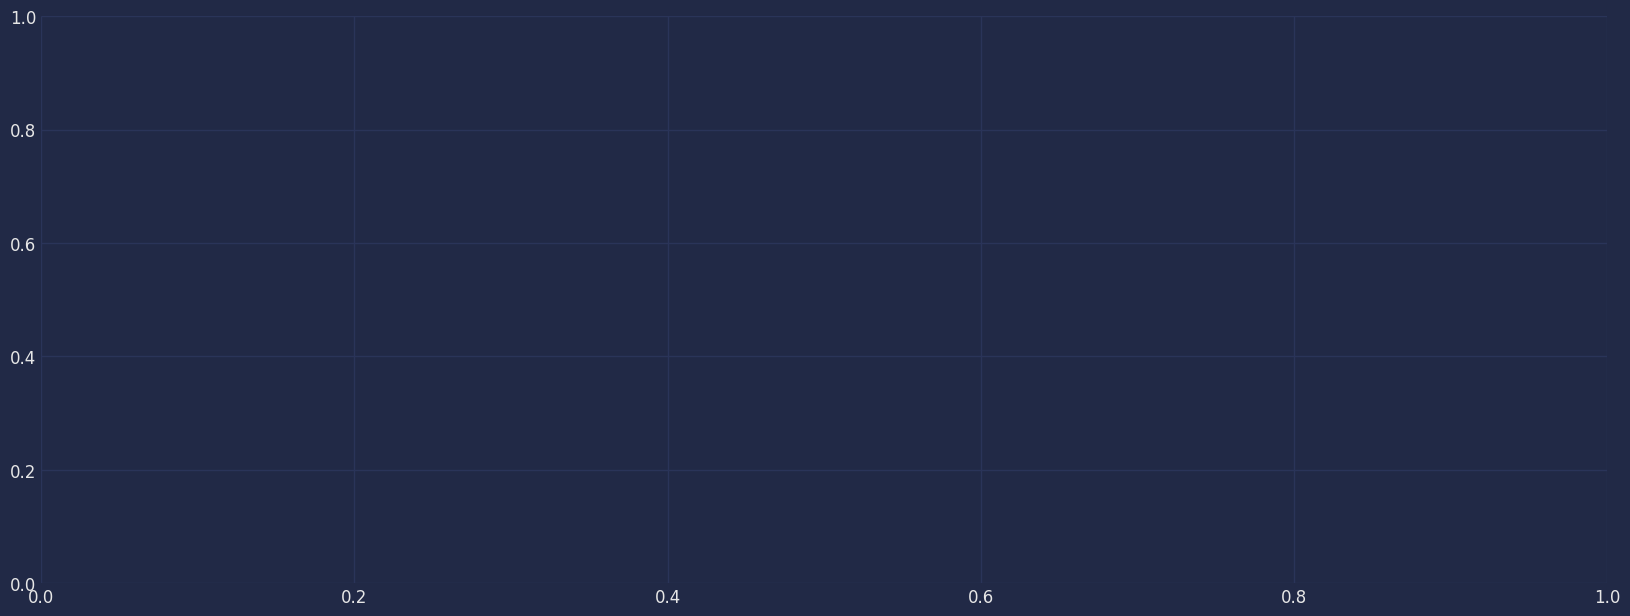

In [62]:

fig, ax = plt.subplots()
plt.plot_date(df_plot.index, df_plot["y"],label="Actual", linestyle="-")
plt.plot_date(df_plot.index, df_plot["hat"],label="Forecas", linestyle="-")
ax.fill_between(df_plot.index,
                df_plot['lo-80'],
                df_plot['hi-80'],
                alpha=.35,
                color='orange',
                label='AutoETS-level-95')
ax.set_title('', fontsize=22)
ax.set_ylabel('', fontsize=20)
ax.set_xlabel('Timestamp [t]', fontsize=12)
plt.legend(fontsize=12)
ax.grid(True)

plt.show()


In [64]:
autoets.predict_in_sample()

{'fitted': array([ 30.92468695,  30.88700671,  27.16857333,  25.50338042,
         27.68642146,  24.27724792,  24.8052603 ,  36.68834099,
         41.16560982,  50.07832846,  50.05927849,  46.86920027,
         54.48519261,  62.38138575,  68.2539064 ,  60.05998924,
         59.60059755,  63.1096306 ,  67.08760723,  72.43138085,
         74.59518155,  78.80232125,  74.76528869,  77.46648858,
         77.78575756,  75.68233927,  78.73263561,  81.97286625,
         78.53388275,  78.95224393,  85.51187907,  93.7269845 ,
         89.16200134,  89.63008777, 101.6626989 , 103.92685944,
        104.34579093, 111.87240858, 106.59957214, 113.75677627,
        117.22669613, 118.45323122, 113.93740231, 123.56699196,
        125.74119186, 127.88474198, 130.59651529, 118.06576736,
        114.70497936, 129.92729537, 135.13259709, 141.62294709,
        149.79814785, 151.00521986, 150.52682702, 168.74012185,
        171.45350976, 170.35718057, 179.51856924, 176.64841937,
        175.93036966, 186.3279

In [65]:
autoets.forecast(y=train["y"].values, h=6, fitted=True)

{'mean': array([262.35315026, 264.74045909, 267.12776792, 269.51507676,
        271.90238559, 274.28969442]),
 'fitted': array([ 30.15079477,  33.17464999,  30.3678771 ,  28.54786062,
         30.18932814,  27.46269204,  27.55025732,  37.83869219,
         43.10220385,  51.52207781,  52.6443309 ,  50.03708179,
         56.27072156,  63.94252084,  70.05883291,  63.79961157,
         62.55545268,  65.4215323 ,  69.24921911,  74.38822436,
         76.95446944,  80.93987298,  77.98735943,  79.92385088,
         80.4615937 ,  78.7149733 ,  81.11644683,  84.24325247,
         81.69181037,  81.70826358,  87.38318018,  95.25524465,
         92.37192105,  92.38654988, 102.79443586, 106.16013107,
        106.9775707 , 113.59719467, 109.93221493, 115.62607676,
        119.39685192, 120.96746559, 117.2742467 , 125.10242571,
        128.04131983, 130.29250274, 132.94201397, 122.4631323 ,
        118.13891618, 130.71836408, 136.92134342, 143.3733787 ,
        151.31613454, 153.43425836, 153.30687167

In [66]:
autoets.forecast(y=train["y"].values, h=6, fitted=True, level=[95])

{'mean': array([262.35315026, 264.74045909, 267.12776792, 269.51507676,
        271.90238559, 274.28969442]),
 'fitted': array([ 30.15079477,  33.17464999,  30.3678771 ,  28.54786062,
         30.18932814,  27.46269204,  27.55025732,  37.83869219,
         43.10220385,  51.52207781,  52.6443309 ,  50.03708179,
         56.27072156,  63.94252084,  70.05883291,  63.79961157,
         62.55545268,  65.4215323 ,  69.24921911,  74.38822436,
         76.95446944,  80.93987298,  77.98735943,  79.92385088,
         80.4615937 ,  78.7149733 ,  81.11644683,  84.24325247,
         81.69181037,  81.70826358,  87.38318018,  95.25524465,
         92.37192105,  92.38654988, 102.79443586, 106.16013107,
        106.9775707 , 113.59719467, 109.93221493, 115.62607676,
        119.39685192, 120.96746559, 117.2742467 , 125.10242571,
        128.04131983, 130.29250274, 132.94201397, 122.4631323 ,
        118.13891618, 130.71836408, 136.92134342, 143.3733787 ,
        151.31613454, 153.43425836, 153.30687167

In [67]:
autoets.forward(train["y"].values, h=6)

{'mean': array([257.5560135, 257.5560135, 257.5560135, 257.5560135, 257.5560135,
        257.5560135])}

In [68]:
from sklearn import metrics

In [69]:
def model_evaluation(y_true, y_pred, model):

    def mean_absolute_percentage_error(y_true, y_pred):
        y_true, y_pred = np.array(y_true), np.array(y_pred)
        return np.mean(np.abs((y_true - y_pred) / y_true)) * 100
    print (f'Model Evaluation: {model}')
    print(f'MSE is : {metrics.mean_squared_error(y_true, y_pred)}')
    print(f'MAE is : {metrics.mean_absolute_error(y_true, y_pred)}')
    print(f'RMSE is : {np.sqrt(metrics.mean_squared_error(y_true, y_pred))}')
    print(f'MAPE is : {mean_absolute_percentage_error(y_true, y_pred)}')
    print(f'R2 is : {metrics.r2_score(y_true, y_pred)}')
    print(f'corr is : {np.corrcoef(y_true, y_pred)[0,1]}',end='\n\n')


In [70]:
model_evaluation(test["y"], forecast["hat"], "AutoETS")


Model Evaluation: AutoETS


ValueError: Found input variables with inconsistent numbers of samples: [35, 6]